In [1]:
import os
import re
import shutil
import sys
from datetime import date

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import *
from deconv import *

In [2]:
%matplotlib notebook

## Example Bipolar Data (2021_06_30)
### In each table:                                                             
* column 1 & 2 : static spot stimulus_200um (two trials)                       
* column 3 & 4 : snake stimulus_500um/s (two trials)                           
* column 5 & 6 : moving spot stimulus_500um/s (two trials)                     

**Scan rate for all**: 58.25 Hz                                                
**ROI size**: 5 um.

In [3]:
base_path = "/mnt/Data/prerna_velocity/"
data_path = os.path.join(base_path, "2021_06_30/waveforms/")
stim_labels = ["static_spot", "snake", "moving_spot"]
n_trials = 2
hz = 58.25
dt = 1 / hz

roi_data = {
    d: np.stack(
        [
            pd.read_csv(os.path.join(data_path, d, f), skiprows=1).values.T
            for f in os.listdir(os.path.join(data_path, d))
        ], 
        axis=0
    ) 
    for d in ["DD", "PD"]
}

recs = {
    d: {
        s: rois[:, i * n_trials:i * n_trials + n_trials]
        for i, s in enumerate(stim_labels)
    }  
    for d, rois in roi_data.items()
}

normed = {
    d: {s: rs / np.max(rs, axis=2, keepdims=True) for s, rs in rois.items()} 
    for d, rois in recs.items()
}

avg_recs = {
    d: {s: np.mean(rs, axis=1) for s, rs in rois.items()} 
    for d, rois in recs.items()
}

avg_normed = {
    d: {s: np.mean(rs, axis=1) for s, rs in rois.items()} 
    for d, rois in normed.items()
}

n_rois, n_trials, n_pts = recs["DD"]["snake"].shape
rec_xaxis = np.arange(n_pts) * dt

### Data Overview (plots of all ROIs for both scan-fields)

<IPython.core.display.Javascript object>


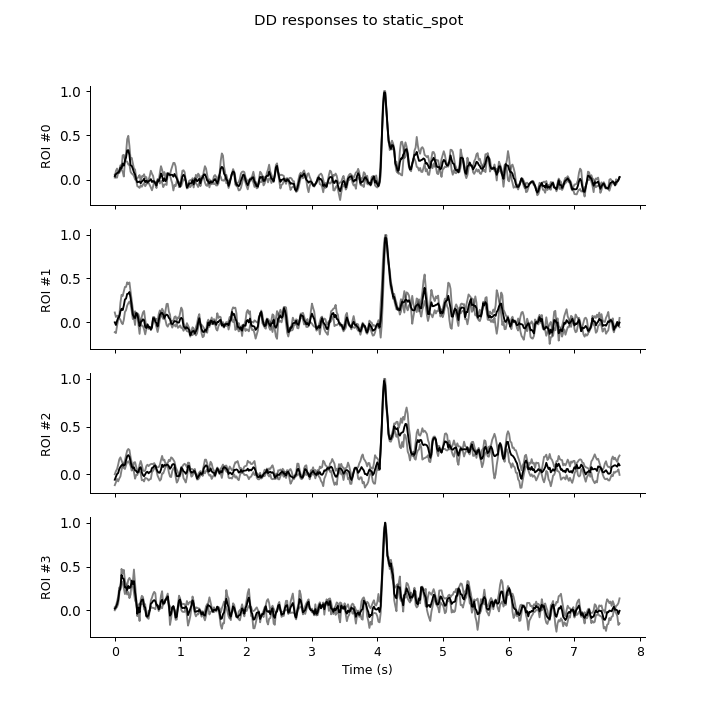

<IPython.core.display.Javascript object>


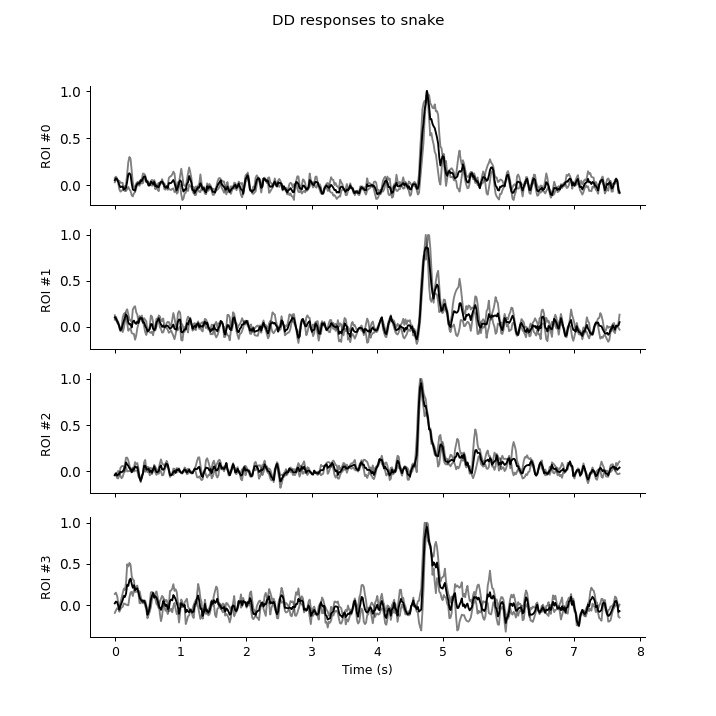

<IPython.core.display.Javascript object>


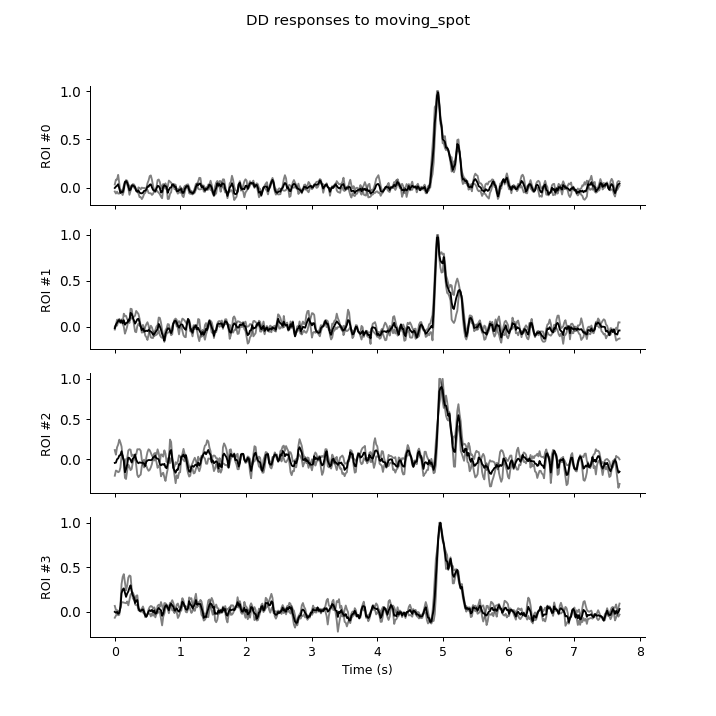

<IPython.core.display.Javascript object>


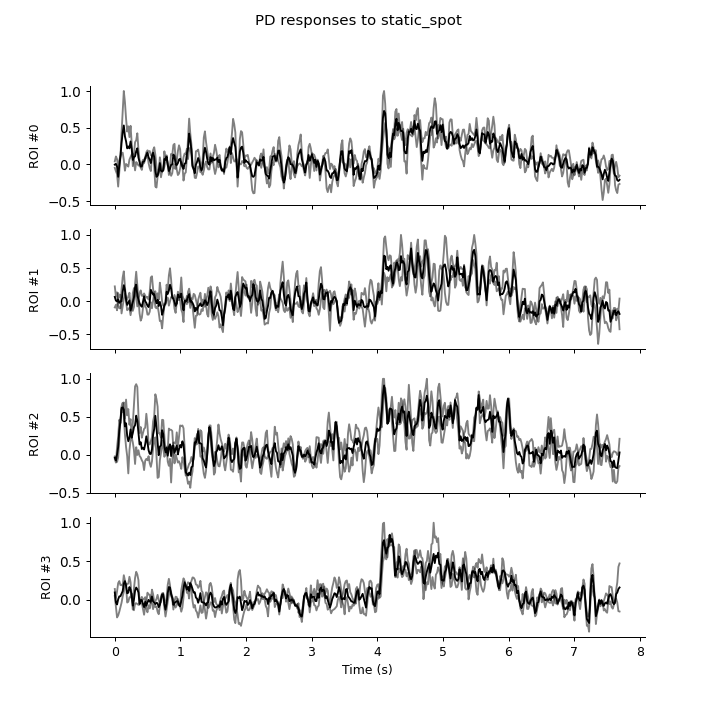

<IPython.core.display.Javascript object>


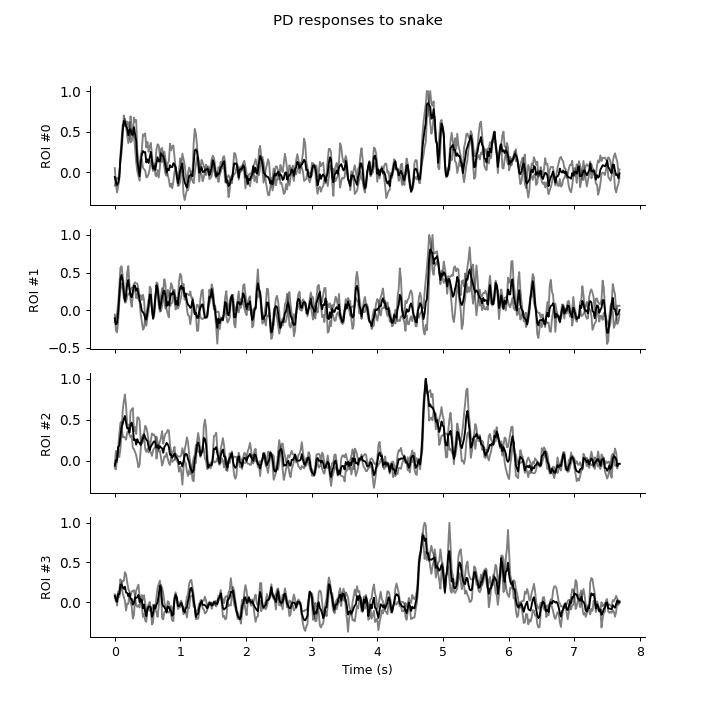

<IPython.core.display.Javascript object>


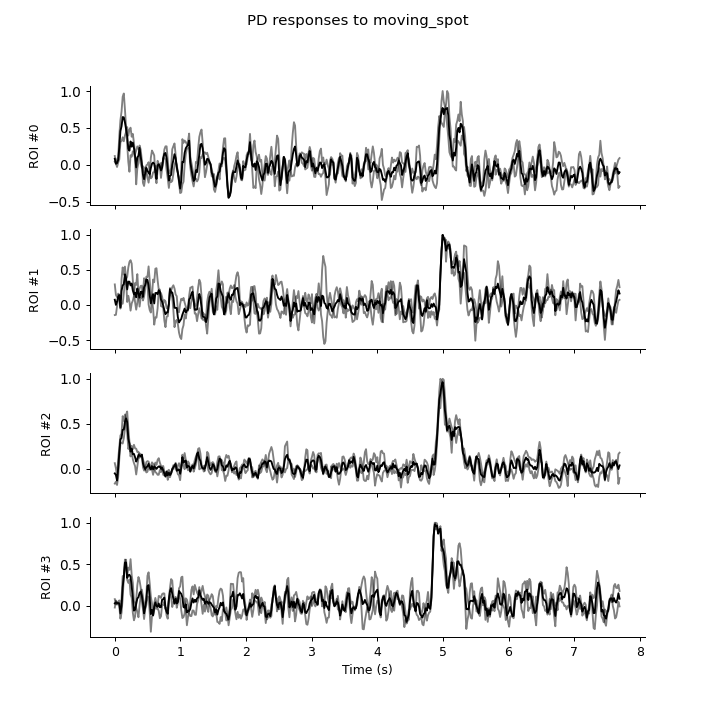

In [4]:
figures = {}
for depth, stims in normed.items():
    figures[depth] = {}
    for stim, rois in stims.items():
        figures[stim] = {}
        figures[stim]["fig"], figures[stim]["ax"] = plt.subplots(
            n_rois, sharex=True, figsize=(8, 8)
        )
        for i, trials in enumerate(rois):
            for tr in trials:
                figures[stim]["ax"][i].plot(rec_xaxis, tr, c="black", alpha=0.5)

            av = np.mean(trials, axis=0)
            figures[stim]["ax"][i].plot(rec_xaxis, av, c="black")
            figures[stim]["ax"][i].set_ylabel("ROI #%i" % i)
            clean_axes(figures[stim]["ax"][i])


        figures[stim]["fig"].suptitle("%s responses to %s" % (depth, stim))
        figures[stim]["ax"][-1].set_xlabel("Time (s)")
        figures[stim]["fig"].show()

### QSE estimation from static spot responses in the proximal scan field
- steady state QSEs calculated with the relatively flat section of the responses (with the exception of the moving spot which has no such region
- base QSEs calculated from a stable window of the baseline preceding the response

In [5]:
windows = {
    "static_spot": {"steady": {0: 4.4, 1: 6.0}, "base": {0: 1., 1: 3.5}},
    "snake": {"steady": {0: 5., 1: 6.0}, "base": {0: 1.5, 1: 3.5}},
    "moving_spot": {"steady": {0: 4.8, 1: 5.3}, "base": {0: 1., 1: 4.}},
}
qses, avg_qses = {}, {}

for stim, rois in normed["PD"].items():
    qses[stim], avg_qses[stim] = [{"steady": [], "base": []} for _ in range(2)]
    steady_start = nearest_index(rec_xaxis, windows[stim]["steady"][0])
    steady_stop = nearest_index(rec_xaxis, windows[stim]["steady"][1])
    base_start = nearest_index(rec_xaxis, windows[stim]["base"][0])
    base_stop = nearest_index(rec_xaxis, windows[stim]["base"][1])
    for i, trials in enumerate(rois):
        for tr in trials:
            qses[stim]["steady"].append(quantal_size_estimate(tr[steady_start:steady_stop]))
            qses[stim]["base"].append(quantal_size_estimate(tr[base_start:base_stop]))
    
        av = np.mean(trials, axis=0)
        avg_qses[stim]["steady"].append(quantal_size_estimate(av[steady_start:steady_stop]))
        avg_qses[stim]["base"].append(quantal_size_estimate(av[base_start:base_stop]))
    
    print("Quantal Size Estimates for %s:" % stim)
    for k in qses[stim].keys():
        qses[stim][k] = np.array(qses[stim][k])
        avg_qses[stim][k] = np.array(avg_qses[stim][k])
        print("  period:", k)
        print("    per-trial:", np.round(qses[stim][k], decimals=3)) 
        print("      mean: %.3f" % np.mean(qses[stim][k]))
        print("    averaged trials:", np.round(avg_qses[stim][k], decimals=3))
        print("      mean: %.3f" % np.mean(avg_qses[stim][k]))
    print("")

Quantal Size Estimates for static_spot:
  period: steady
    per-trial: [0.306 0.099 0.261 0.419 0.298 0.141 0.171 0.102]
      mean: 0.225
    averaged trials: [0.091 0.184 0.123 0.059]
      mean: 0.114
  period: base
    per-trial: [ 2.485  1.259 38.538 33.574  1.871  2.845  0.751 -0.989]
      mean: 10.042
    averaged trials: [ 1.123 17.359  1.217  1.259]
      mean: 5.240

Quantal Size Estimates for snake:
  period: steady
    per-trial: [0.248 0.203 0.475 0.198 0.321 0.118 0.297 0.097]
      mean: 0.245
    averaged trials: [0.14  0.153 0.114 0.094]
      mean: 0.125
  period: base
    per-trial: [-22.239   3.393   8.315   5.125  -1.192   1.334  -1.538 -63.108]
      mean: -8.739
    averaged trials: [ 5.045  3.616 -1.665 -1.385]
      mean: 1.403

Quantal Size Estimates for moving_spot:
  period: steady
    per-trial: [0.918 0.642 0.91  0.467 0.314 0.391 0.283 0.309]
      mean: 0.529
    averaged trials: [0.584 0.628 0.32  0.263]
      mean: 0.449
  period: base
    per-trial:

### Generate representative biexponential quantal event
Rough representation of an iGluSnFr mini from a bipolar terminal

using qse = 0.22457


<IPython.core.display.Javascript object>


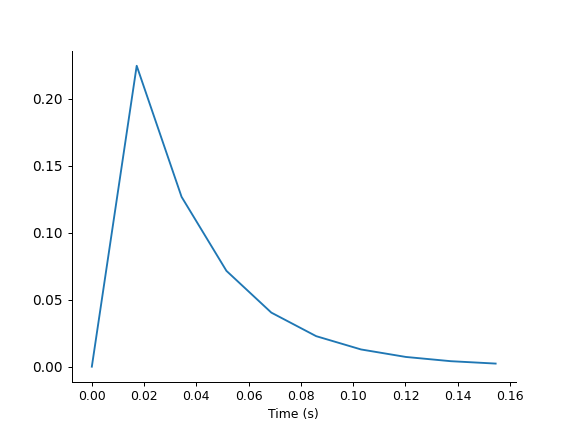

In [6]:
tau1 = 2 # rise [ms]
tau2 = 30  # decay [ms]
quantum_pts = 10

fitter = BiexpFitter(1, 10, norm_amp=True)
biexp_quantum = fitter.model(
    t=np.arange(quantum_pts), 
    tau1=tau1 / 1000 / dt, # convert to match resulting sample-rate to data
    tau2=tau2 / 1000 / dt, 
    y0=1.,
)[0]
biexp_xaxis = np.arange(quantum_pts) * dt

qse = np.mean(qses["static_spot"]["steady"])
qse_quantum = biexp_quantum * qse
print("using qse = %.5f" % qse)

biexp_fig, biexp_ax = plt.subplots(1)
biexp_ax.plot(biexp_xaxis, qse_quantum)
biexp_ax.set_xlabel("Time (s)")
clean_axes(biexp_ax)
biexp_fig.show()

### Run through quantal analysis with example waveform

In [7]:
depth = "PD"
stim = "snake"
roi_idx = 0
trial_idx = 0
ev = recs[depth][stim][roi_idx, trial_idx]
quantum_fft = np.fft.rfft(qse_quantum, n=len(ev))
rec_fft = np.fft.rfft(ev)
inv = np.fft.irfft(rec_fft / quantum_fft)
deconv = np.convolve(inv, qse_quantum)

bin_t = 0.05  # st
# bin_t = dt  # s
sz = int(bin_t / dt)
bin_edges = np.arange(sz, len(inv) + sz, sz) * dt
binned = bin_mean(inv, sz)
print("points per bin:", sz)
print("time per bin: %.2fms" % (sz * dt * 1000))

scale_mode = False
ceiling = 0.95
max_q = 5
q_scale = 1. / max_q if scale_mode else 1.

quanta = raster(binned, thresh=np.max(binned) * ceiling / max_q, max_q=max_q)    
quantal_sum = sum_quanta(quanta, bin_edges, qse_quantum * q_scale, dt)
quantal_sum_xaxis = np.arange(len(quantal_sum)) * dt

points per bin: 2
time per bin: 34.33ms


<IPython.core.display.Javascript object>


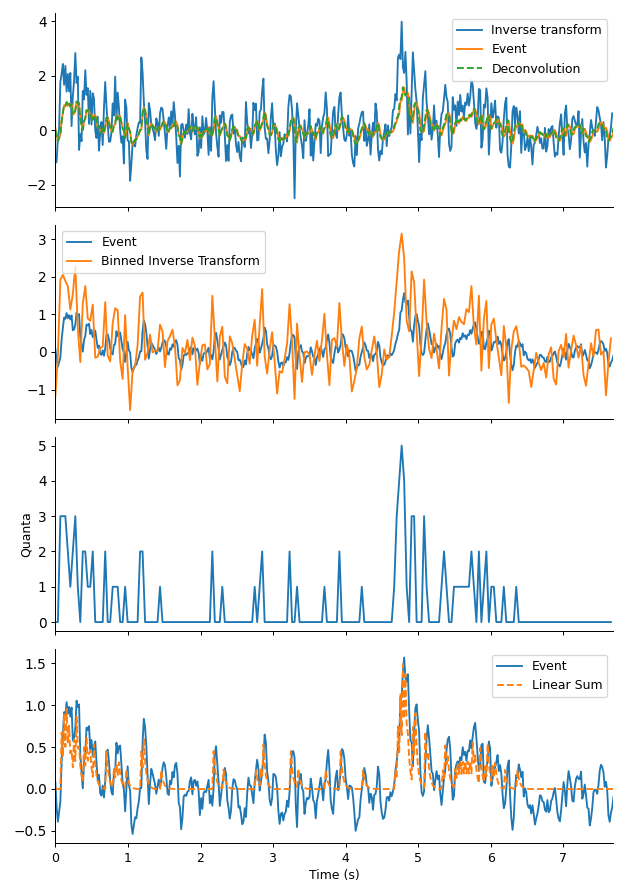

In [8]:
ex_quanta_fig, ex_quanta_ax = plt.subplots(4, sharex=True,figsize=(7, 10))

ex_quanta_ax[0].plot(rec_xaxis[:-1], inv, label="Inverse transform")
ex_quanta_ax[0].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[0].plot(np.arange(len(deconv)) * dt, deconv, label="Deconvolution", linestyle="--")
ex_quanta_ax[0].legend()

ex_quanta_ax[1].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[1].plot(bin_edges, binned, label="Binned Inverse Transform")
ex_quanta_ax[1].legend()

ex_quanta_ax[2].plot(bin_edges, quanta)
ex_quanta_ax[2].set_ylabel("Quanta")

ex_quanta_ax[3].plot(rec_xaxis, ev, label="Event")
ex_quanta_ax[3].plot(quantal_sum_xaxis, quantal_sum, label="Linear Sum", linestyle="--")
ex_quanta_ax[3].set_xlim(0, np.max(rec_xaxis))
ex_quanta_ax[3].legend()
ex_quanta_ax[3].set_xlabel("Time (s)")

for ax in ex_quanta_ax:
    clean_axes(ax)

ex_quanta_fig.tight_layout()
ex_quanta_fig.show()

## TODO:
* compare max number of quanta (MSE, what gets the best fit, show figure)
* generate figures with many examples of this method of estimating quantal events
 * proximal vs distal
 * each stimuli
 * different ROIs

### Run quantal analysis on all recordings
- All trials, of all ROIs, from both proximal and distal scan fields
- Run through with a range of maximum quanta count (`max_q`) values

In [9]:
def quantify(data, bin_t=0.05, ceiling=0.95, max_q=5, scale_mode=False):
    res = {}
    for depth, stims in data.items():
        res[depth] = {}
        for stim, rois in stims.items():
            res[depth][stim] = {}
            (
                res[depth][stim]["quanta"], 
                res[depth][stim]["quanta_xaxis"], 
                res[depth][stim]["quantal_sum"],
                res[depth][stim]["quantal_sum_xaxis"],
            ) = get_quanta(
                    rois, 
                    qse_quantum, 
                    dt, 
                    bin_t=bin_t,
                    ceiling=ceiling,
                    max_q=max_q,
                    scale_mode=scale_mode
                )
    return res

quantifications = {i: quantify(recs, max_q=i) for i in range(1, 15)}

### Calculate Mean Squared Error to see how the quantal sums fit to the original data depends on the maximum number of quanta per time bin

<IPython.core.display.Javascript object>


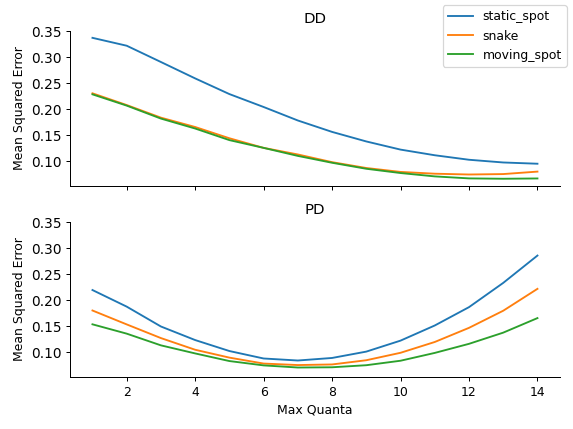

In [10]:
mses = {d: {s: [] for s in stim_labels} for d in ["DD", "PD"]}
for n, data in quantifications.items():
    for depth, stims in data.items():
        for stim, quants in stims.items():
            r = recs[depth][stim]
            diff = r - quants["quantal_sum"][:, :, :r.shape[-1]]  # truncate to same shape
            mses[depth][stim].append(np.mean(diff ** 2))

mse_xaxis = np.array(list(quantifications.keys()))
mses = {d: {s: np.array(es) for s, es in stims.items()} for d, stims in mses.items()}

mse_fig, mse_ax = plt.subplots(2, sharex=True, sharey=True)
for i, ((depth, stims), ax) in enumerate(zip(mses.items(), mse_ax)):
    for stim, errors in stims.items():
        lbl = stim if not i else None
        ax.plot(mse_xaxis, errors, label=lbl)
    
    ax.set_title(depth)
    ax.set_ylabel("Mean Squared Error")
    clean_axes(ax)

mse_ax[-1].set_xlabel("Max Quanta")
mse_fig.legend()
mse_fig.tight_layout()
mse_fig.show()